## Load libraries and data

In [115]:
# load relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime

In [233]:
# load the data by reading the raw csv file
# use parse_dates argument to read the date column in datetime format
btc = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=['Timestamp'], usecols=['Timestamp', 'Weighted_Price'])

In [234]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


## Explore the data

In [235]:
btc.shape

(4857377, 2)

In [236]:
# check data types
btc.dtypes

Timestamp          object
Weighted_Price    float64
dtype: object

In [237]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


In [238]:
btc.tail()

,Timestamp,Weighted_Price
4857372,1617148560,58692.753339
4857373,1617148620,58693.226508
4857374,1617148680,58696.198496
4857375,1617148740,58761.866202
4857376,1617148800,58764.349363


### Check and drop null values

In [239]:
# check how many rows have non-null values
btc.notnull().sum()

Timestamp         4857377
Weighted_Price    3613769
dtype: int64

As there are over 1 million rows having null value, I'm going to drop them.

In [240]:
# drop null rows
btc = btc.dropna()

In [241]:
# check if null values are all removed
btc.isnull().values.any()

False

In [242]:
btc.shape

(3613769, 2)

In [243]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
478,1325346600,4.390000
547,1325350740,4.526411
548,1325350800,4.580000
1224,1325391360,4.580000


### Reset index

In [244]:
btc.reset_index(drop=True, inplace=True)
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
1,1325346600,4.390000
2,1325350740,4.526411
3,1325350800,4.580000
4,1325391360,4.580000


## Cleaning, transforming and visualizing

### The timestamps are in Unix time so I'm going to transform it to datetime

In [245]:
btc['Timestamp'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.dtypes

Timestamp         datetime64[ns]
Weighted_Price           float64
dtype: object

In [246]:
btc.head(5)

,Timestamp,Weighted_Price
0,2011-12-31 07:52:00,4.390000
1,2011-12-31 15:50:00,4.390000
2,2011-12-31 16:59:00,4.526411
3,2011-12-31 17:00:00,4.580000
4,2012-01-01 04:16:00,4.580000


In [247]:
btc.tail(5)

,Timestamp,Weighted_Price
3613764,2021-03-30 23:56:00,58692.753339
3613765,2021-03-30 23:57:00,58693.226508
3613766,2021-03-30 23:58:00,58696.198496
3613767,2021-03-30 23:59:00,58761.866202
3613768,2021-03-31 00:00:00,58764.349363


### Plot the data

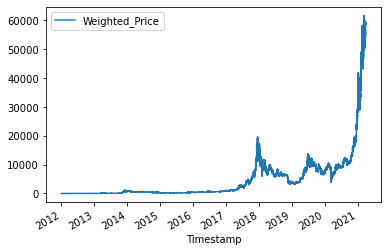

In [248]:
btc.plot(x='Timestamp', y='Weighted_Price')
plt.show()

### Downsample to daily data

In [263]:
btc.index = btc['Timestamp']
daily = btc.resample('D').mean()
daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


In [264]:
type(daily)

pandas.core.frame.DataFrame

In [266]:
btc_daily = daily['Weighted_Price']
type(btc_daily)

pandas.core.series.Series

In [276]:
btc_daily = btc_daily.dropna()

In [277]:
btc_daily.isnull().values.any()

False

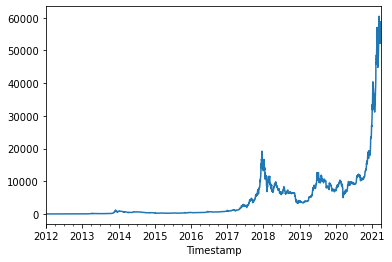

In [267]:
btc_daily.plot()

### Check if data is stationary

In [278]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

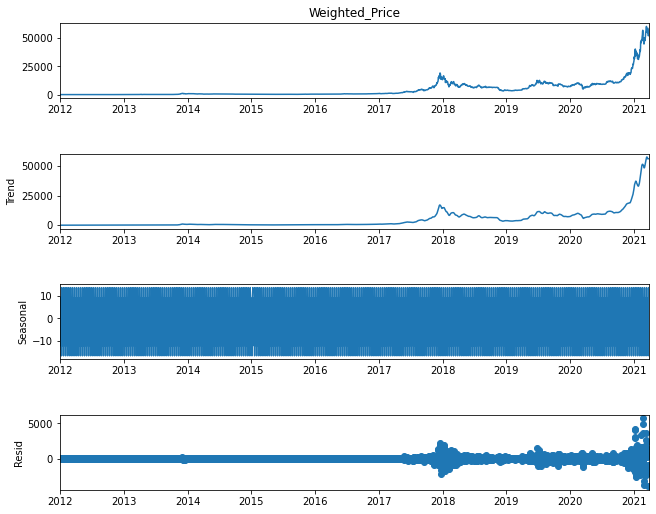

In [287]:
# Seasonal Decomposition
# observed = trend + seasonal + resid
# period(=freq) : seosonal을 볼때 주기

decomposition = sm.tsa.seasonal_decompose(btc_daily, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Does data have:  
- Trend? Increasing  
- Seasonality? No  
- Residual? Increasing

We can see that the data is non-stationarity as the average is different by time.

### Plot the ACF and PACF on the daily data in order to find the best model order

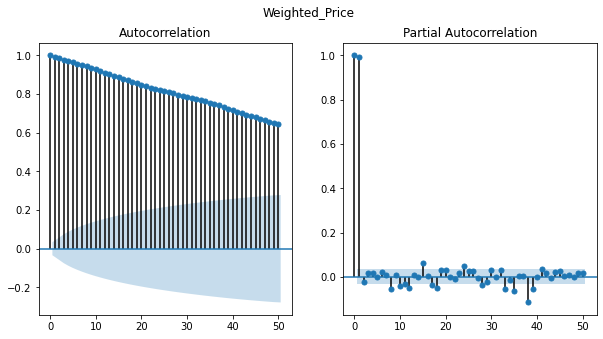

In [286]:
# Plot acf and pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Weighted_Price')
sm.graphics.tsa.plot_acf(btc_daily.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(btc_daily.values.squeeze(), lags=50, ax=ax[1]);

The ACF tails off slowly and PACF cuts off after lag 1 so I'm taking AR(1), and it needs to be differenced.

### Taking the difference

##### 1st order differencing

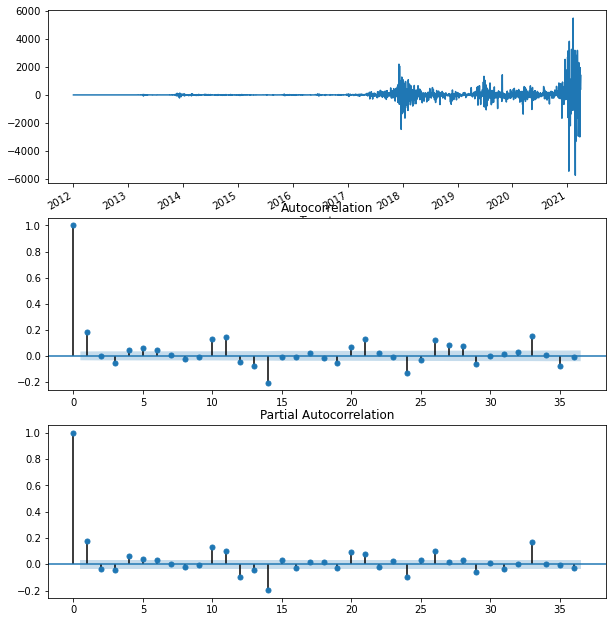

In [295]:
btc_daily_diff_1 = btc_daily.diff(periods=1).iloc[1:]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
btc_daily_diff_1.plot(ax=ax1)
plot_acf(btc_daily_diff_1, ax=ax2)
plot_pacf(btc_daily_diff_1, ax=ax3)
plt.show()

It looks stationary now so it would be good enough to take the 1st order differencing.  
As a result, I'll take ARIMA(1, 1, 0) model.

### Split train-test data - remove the last one month data (use this for test) and train

### Apply modeling - ARIMA

### Result verification